<a href="https://colab.research.google.com/github/daehkim/RL-lecture/blob/master/lab6-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

**Code: Network and setup**

In [0]:
def one_hot(x):
  return np.identity(16)[x:x+1]

In [0]:
env = gym.make('FrozenLake-v0')

In [0]:
# Input and output size based on the Env
input_size = env.observation_space.n # Number of states, it is 16 for Frozenlake
output_size = env.action_space.n # Number of action, it is 4 for FrozenLake
learning_rate = 0.1

In [0]:
# These lines establish the feed-forward part of the network used to choose actions
X = tf.placeholder(shape=[1, input_size], dtype=tf.float32) # state input / placeholder는 밖에서 값을 주는 듯.
W = tf.Variable(tf.random_uniform([input_size, output_size], 0, 0.01)) # weight 16x4 / Variable has a state

Qpred = tf.matmul(X, W) # Out Q prediction
Y = tf.placeholder(shape=[1, output_size], dtype=tf.float32) # Ylabel

In [0]:
loss = tf.reduce_sum(tf.square(Y - Qpred))
train = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

# Set Q-learning related parameters
dis = .99
num_episodes = 2000

# Create lists to contain total rewards and steps per episode
rList = []

**Code: Training**

In [0]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init)
  for i in range(num_episodes):
    # Reset environment and get first new observation
    s = env.reset()
    e = 1. / ((i / 50) + 10) # Noise starting from 0.1 ~ 0
    rAll = 0
    done = False
    local_losee = []

    # The Q-Network training
    while not done:
      # Choose an action by greedily (with e chance of random action) from the Q-network
      Qs = sess.run(Qpred,feed_dict={X: one_hot(s)})
      if np.random.rand(1) < e:
        a = env.action_space.sample() # Randomly choose the action
      else:
        a = np.argmax(Qs)

      # Get new state and reward from environment
      s1, reward, done, _ = env.step(a)
      if done:
        # Update Q, and no Qs+1, since it's a terminal state
        Qs[0, a] = reward
      else:
        # Obtain the Q_s1 values by feeding the new state through our network
        Qs1 = sess.run(Qpred, feed_dict={X: one_hot(s1)})
        # Update Q
        Qs[0, a] = reward + dis * np.max(Qs1)

      # Train our network using target (Y) and predicted Q (Qpred) values
      sess.run(train, feed_dict = {X: one_hot(s), Y: Qs})

      rAll += reward
      s = s1
    rList.append(rAll)

Percent of successful episodes: 0.281


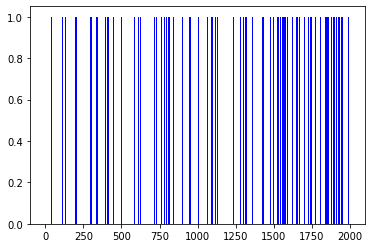

In [13]:
print("Percent of successful episodes: " + str(sum(rList)/num_episodes))
plt.bar(range(len(rList)), rList, color="blue")
plt.show()